In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import h5py
from tqdm import tqdm

In [18]:
#initialize constants (SI units)
c = 2.99792458e8 #speed of light
m_e = 9.10938356e-31
q_e = 1.60217662e-19
e_0 = 8.85418782e-12
#set pure spectral properties
lambda_0 = 800e-9 #central wavelength
tau_0 = 10e-15 #FL pulse duration 1/e2 intensity half-width (same def as beam waist)
#quick frequency properties
omega_0 = 2*np.pi*c/lambda_0
#set initial beam waist
w_00 = 4e-6
#calculate Rayleigh range and beam waist
z_R0 = (omega_0*w_00**2)/(2*c)
z_R = np.copy(z_R0)
w_0 = np.copy(w_00)
# perturbation parameter
eps = w_0/z_R

In [19]:
GDD_0 = 0 #Group Delay Dispersion fs^2
GDD = GDD_0*(1e-15)**2
tau_p = np.sqrt(tau_0**2 + (2*GDD/tau_0)**2)
Psi_0 = 4.5
z_0 = 0.032*z_R0
# beam power
P_corr = 1 + 3*(eps/2)**2 + 9*(eps/2)**4
P = 80e12
Amp = np.sqrt(8*P/(P_corr*np.pi*e_0*c)) * (omega_0/(2*c))
# set tuning parameters
r_0 = np.linspace(0,lambda_0/2,200)

In [20]:
z_final = np.empty(len(r_0))
r_final = np.empty(len(r_0))
v_z_final = np.empty(len(r_0))
v_r_final = np.empty(len(r_0))
gamma_final = np.empty(len(r_0))
KE_final = np.empty(len(r_0))

t_start = -10*tau_0
t_end = +200*tau_0
n = 200
num_t = np.int_(np.round(n*(t_end-t_start)/(lambda_0/c)))

time = np.linspace(t_start,t_end,num_t)
dt = time[1]-time[0]

for j in tqdm(range(0, len(r_0))):
    z = np.empty(shape=(len(time)))
    r = np.empty(shape=(len(time)))
    v_z = np.empty(shape=(len(time)))
    v_r = np.empty(shape=(len(time)))
    gamma = np.empty(shape=(len(time)))
    KE = np.empty(shape=(len(time)))
    deriv2 = np.empty(shape=(len(time)))
    deriv4 = np.empty(shape=(len(time)))

    z[0] = z_0
    r[0] = r_0[j]
    v_z[0] = 0.0
    v_r[0] = 0.0
    gamma[0] = 1.0
    # do 5th order Adams-Bashforth finite difference method
    for k in range(0, len(time)-1):      
        phi_G = np.arctan(z[k]/z_R)
        w = w_0*np.sqrt(1+(z[k]/z_R)**2)
        if z[k] == 0.0:
            R = np.inf
        else:
            R = z[k] + (z_R**2)/z[k]
        phi_norm = Psi_0+omega_0*time[k]-(omega_0/c)*(z[k]+(r[k]**2)/(2*R))
        trans = np.exp(-(r[k]/w)**2)

        c_2 = (w_0/w)**2 * np.exp(1j*(phi_norm + 2*phi_G))
        c_3 = (w_0/w)**3 * np.exp(1j*(phi_norm + 3*phi_G))
        c_4 = (w_0/w)**4 * np.exp(1j*(phi_norm + 4*phi_G))
        c_5 = (w_0/w)**5 * np.exp(1j*(phi_norm + 5*phi_G))
        c_6 = (w_0/w)**6 * np.exp(1j*(phi_norm + 6*phi_G))
        c_7 = (w_0/w)**7 * np.exp(1j*(phi_norm + 7*phi_G))
        c_8 = (w_0/w)**8 * np.exp(1j*(phi_norm + 8*phi_G))

        rho = r[k]/w_0

        env_temp = np.exp(-((phi_norm-Psi_0)/(omega_0*tau_p))**2)
        temp_phase = np.exp(1j*(2*GDD/(tau_0**4+(2*GDD)**2))*(time[k]-z[k]/c)**2)
        pulse_prep = (tau_0/tau_p)*env_temp*temp_phase

        E_z_time = pulse_prep*((c_2 - c_3*rho**2)*eps**2 +
                               ((1/2)*c_3 + (1/2)*c_4*rho**2 - (5/4)*c_5*rho**4 + (1/4)*c_6*rho**6)*eps**4)

        E_r_time = pulse_prep*((c_2*rho)*eps +
                               (-(1/2)*c_3*rho + c_4*rho**3 - (1/4)*c_5*rho**5)*eps**3 +
                               (-(3/8)*c_4*rho - (3/8)*c_5*rho**3 + (17/16)*c_6*rho**5 -
                                (3/8)*c_7*rho**7 + (1/32)*c_8*rho**9)*eps**5)*np.exp(+1j*np.pi/2)

        B_t_time = pulse_prep*((c_2*rho)*eps +
                               ((1/2)*c_3*rho + (1/2)*c_4*rho**3 - (1/4)*c_5*rho**5)*eps**3 +
                               ((3/8)*c_4*rho + (3/8)*c_5*rho**3 + (3/16)*c_6*rho**5 -
                                (1/4)*c_7*rho**7 + (1/32)*c_8*rho**9)*eps**5)*np.exp(+1j*np.pi/2)/c

        E_z_total = np.real(Amp*trans*E_z_time)
        E_r_total = np.real(Amp*trans*E_r_time)
        dot_product = v_z[k]*E_z_total + v_r[k]*E_r_total
        B_t_total = np.real(Amp*trans*B_t_time)

        deriv2[k] = (-q_e/(gamma[k]*m_e))*(E_z_total+v_r[k]*B_t_total-v_z[k]*dot_product/(c**2))
        deriv4[k] = (-q_e/(gamma[k]*m_e))*(E_r_total-v_z[k]*B_t_total-v_r[k]*dot_product/(c**2))

        if k==0:
            z[k+1] = z[k] + dt*v_z[k]
            v_z[k+1] = v_z[k] + dt*deriv2[k]
            r[k+1] = r[k] + dt*v_r[k]
            v_r[k+1] = v_r[k] + dt*deriv4[k]
        elif k==1:
            z[k+1] = z[k] + dt*(1.5*v_z[k]-0.5*v_z[k-1])
            v_z[k+1] = v_z[k] + dt*(1.5*deriv2[k]-0.5*deriv2[k-1])
            r[k+1] = r[k] + dt*(1.5*v_r[k]-0.5*v_r[k-1])
            v_r[k+1] = v_r[k] + dt*(1.5*deriv4[k]-0.5*deriv4[k-1])
        elif k==2:
            z[k+1] = z[k] + dt*((23/12)*v_z[k]-(4/3)*v_z[k-1]+(5/12)*v_z[k-2])
            v_z[k+1] = v_z[k] + dt*((23/12)*deriv2[k]-(4/3)*deriv2[k-1]+(5/12)*deriv2[k-2])
            r[k+1] = r[k] + dt*((23/12)*v_r[k]-(4/3)*v_r[k-1]+(5/12)*v_r[k-2])
            v_r[k+1] = v_r[k] + dt*((23/12)*deriv4[k]-(4/3)*deriv4[k-1]+(5/12)*deriv4[k-2])
        elif k==3:
            z[k+1] = z[k] + dt*((55/24)*v_z[k]-(59/24)*v_z[k-1]+(37/24)*v_z[k-2]-(3/8)*v_z[k-3])
            v_z[k+1] = v_z[k] + dt*((55/24)*deriv2[k]-(59/24)*deriv2[k-1]+(37/24)*deriv2[k-2]-(3/8)*deriv2[k-3])
            r[k+1] = r[k] + dt*((55/24)*v_r[k]-(59/24)*v_r[k-1]+(37/24)*v_r[k-2]-(3/8)*v_r[k-3])
            v_r[k+1] = v_r[k] + dt*((55/24)*deriv4[k]-(59/24)*deriv4[k-1]+(37/24)*deriv4[k-2]-(3/8)*deriv4[k-3])
        else:
            z[k+1] = z[k] + dt*((1901/720)*v_z[k]-(1387/360)*v_z[k-1]+(109/30)*v_z[k-2]-(637/360)*v_z[k-3]+(251/720)*v_z[k-4])
            v_z[k+1] = v_z[k] + dt*((1901/720)*deriv2[k]-(1387/360)*deriv2[k-1]+(109/30)*deriv2[k-2]-(637/360)*deriv2[k-3]+(251/720)*deriv2[k-4])
            r[k+1] = r[k] + dt*((1901/720)*v_r[k]-(1387/360)*v_r[k-1]+(109/30)*v_r[k-2]-(637/360)*v_r[k-3]+(251/720)*v_r[k-4])
            v_r[k+1] = v_r[k] + dt*((1901/720)*deriv4[k]-(1387/360)*deriv4[k-1]+(109/30)*deriv4[k-2]-(637/360)*deriv4[k-3]+(251/720)*deriv4[k-4])

        gamma[k+1] = 1/np.sqrt(1-(v_z[k+1]**2+v_r[k+1]**2)/c**2)
        KE[k+1] = (gamma[k+1]-1)*m_e*c**2/q_e

    z_final[j] = z[-1]
    r_final[j] = r[-1]
    v_z_final[j] = v_z[-1]
    v_r_final[j] = v_r[-1]
    gamma_final[j] = gamma[-1]
    KE_final[j] = KE[-1]

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [54:59<00:00, 16.50s/it]


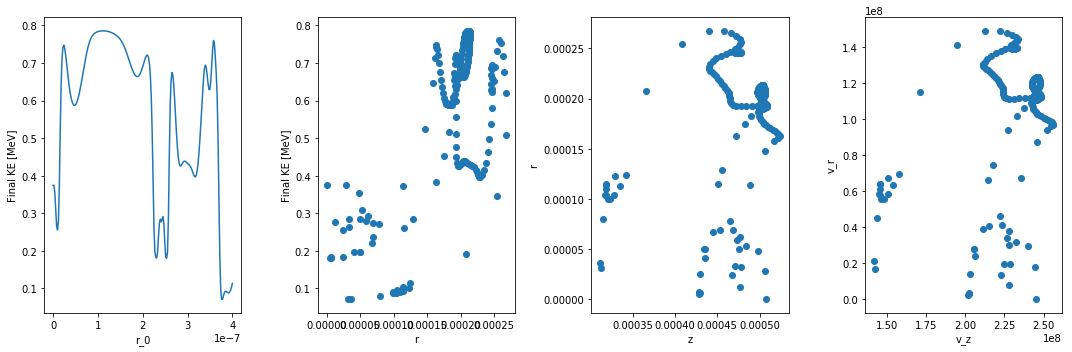

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.plot(r_0, KE_final/1e6)
plt.xlabel('r_0')
plt.ylabel('Final KE [MeV]')
plt.subplot(1,4,2)
plt.plot(np.abs(r_final), KE_final/1e6, ls='none', marker='o')
plt.xlabel('r')
plt.ylabel('Final KE [MeV]')
plt.subplot(1,4,3)
plt.plot(z_final, np.abs(r_final), ls='none', marker='o')
plt.xlabel('z')
plt.ylabel('r')
plt.subplot(1,4,4)
plt.plot(v_z_final, np.abs(v_r_final), ls='none', marker='o')
plt.xlabel('v_z')
plt.ylabel('v_r')

plt.tight_layout()

plt.savefig('NO_STC_2D_Gauss_'+str(np.int_(P/1e12))+'TW_detailed.png')

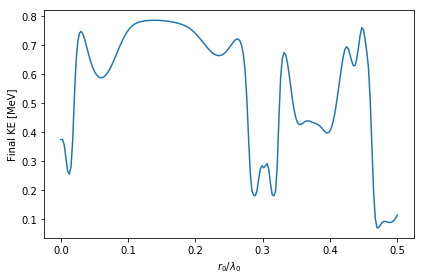

In [22]:
#plt.subplot(1,2,1)
plt.plot(r_0/lambda_0, KE_final/1e6)
plt.xlabel('$r_0$/$\lambda_0$')
plt.ylabel('Final KE [MeV]')
#plt.subplot(1,2,2)
#plt.plot(np.abs(r_final)/w_00, KE_final/1e6, ls='none', marker='o')
#plt.xlabel('$r_{final}$/$w_0$')
#plt.ylabel('Final KE [MeV]')

plt.tight_layout()
plt.savefig('NO_STC_2D_Gauss_'+str(np.int_(P/1e12))+'TW.png')

In [23]:
h5f = h5py.File('NoSTC_2D_Gauss_'+str(np.int_(P/1e12))+'TW_'+str(np.int_(GDD_0))+'fs2.hdf5', 'w')
h5f.create_dataset('r_0', data=r_0)
h5f.create_dataset('KE', data=KE_final)
h5f.create_dataset('v_z', data=v_z_final)
h5f.create_dataset('v_r', data=v_r_final)
h5f.create_dataset('z', data=z_final)
h5f.create_dataset('r', data=r_final)
h5f.close()